# MovieLens 100K dataset, 100K entries in a 943x1682 dimensional matrix

In [1]:
import scipy.sparse
import numpy as np
from multiprocessing.sharedctypes import Array
from ctypes import c_double
from scipy import stats

# Function to permute the matrix according to proposed algorithm

In [5]:
def rearrange(full,ratings):
    n = full.shape[0]
    m = full.shape[1]
    rowsum = full.sum(1)
    colsum = full.sum(0)
    roword = np.argsort(rowsum)
    colord = np.argsort(colsum)
    full = full[roword]
    full = full[:,colord]
    full = full.reshape(n,m)
    ratings = ratings[roword]
    ratings = ratings[:,colord]
    ratings = ratings.reshape(n,m)
    return full,ratings

# Data Preprocessing

In [2]:
def ranking_matrix(N, M, filename, sep="	"):
    
    R = np.zeros((N, M))
    I = np.zeros((N, M))
    f = open(filename,"r")
    for line in f:
        if line[0] == '%':
            # this is a comment
            continue
        (user, movie, ranking,_) = line.split(sep)
        R[np.int(user) - 1, np.int(movie) - 1] = np.int(ranking)
        I[np.int(user) - 1, np.int(movie) - 1] = 1.0
    return R, I

In [3]:
r = 10
n = 943
m = 1682

In [4]:
R, I = ranking_matrix(n, m, "u.data")

# Preparing the permutations of samples to Hogwild

In [8]:
reord,X = rearrange(I,R)

In [9]:
elements = np.count_nonzero(reord)
elements

100000

# Statistics of no. of ratings

Text(0.5, 1.0, 'No.of ratings vs Movies')

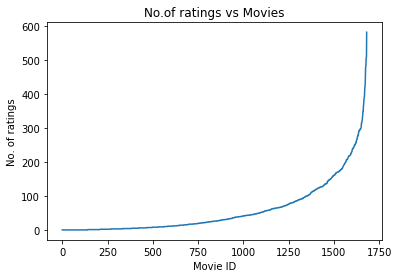

In [33]:
plt.plot(np.arange(m),reord.sum(0))
plt.xlabel("Movie ID")
plt.ylabel("No. of ratings")
plt.title("No.of ratings vs Movies")

Text(0.5, 1.0, 'No.of ratings vs Users')

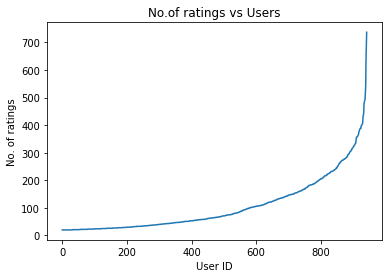

In [34]:
plt.plot(np.arange(n),reord.sum(1))
plt.xlabel("User ID")
plt.ylabel("No. of ratings")
plt.title("No.of ratings vs Users")

# From the above 2 plots we can see that a majority of the ratings come from few users and are about few movies

# Functions to build strata as in SSGD 

In [6]:
def reduce_indices(O,numcores,numdim,px,py):
    maxj = O.shape[0] - 1
    M = (O[:,0] - O[:,1]) % numdim
    M = M.reshape(maxj + 1,1)
    M = np.concatenate((O,M),axis = 1)
    M = M[np.argsort(M[:,2])]
    A = []
    j = 0
    countdim = 0
    while(countdim < numdim):
        countcores = 0
        if(j == maxj + 1):
            return A
        else:
            while(j <= maxj and M[j][2] == countdim):
                A.append((M[j][0]+px,M[j][1]+py))
                j = j + 1
                countcores = countcores + 1
            while(countcores % numcores != 0):
                A.append((-1,-1))
                countcores = countcores + 1
        countdim = countdim + 1
    return A

# Hogwild SGD Function

In [7]:
learning_rate = 0.001
def gradient_step(index):
    i,j = index
    global R
    global C
    global X
    if(i != -1 and j != -1):
        
        err = X[i,j] - np.dot(R[i],C[j])
        grad1 = -2 * err * C[j]
        grad2 = -2 * err * R[i]


        for index in np.where(abs(grad1) > .0001)[0]:
          R_shared[i*r + index] -= learning_rate*grad1[index]

        for index in np.where(abs(grad2) > .0001)[0]:
          C_shared[j*r + index] -= learning_rate*grad2[index]

# Normal Hogwild 

In [10]:
t = 8
pad = 0
px = n - pad
py = m - pad
if(px == n):
    final = []
else:
    s = reord[px:,py:].nonzero()[0].shape[0]
    l = reord[px:,py:].nonzero()[0] 
    d = reord[px:,py:].nonzero()[1] 
    l = l.reshape(s,1)
    d = d.reshape(s,1)
    z = np.concatenate((l,d),axis = 1)
    final = reduce_indices(z,t,n-px,px,py)

In [11]:
if(px == n):
    b1 = 0
else:
    b1 = reord[px:,:py].sum(1).max()
if(px == n):
    b2 = 0
else:
    b2 = reord[:px,py:].sum(0).max()
omega = 2
deltar = max(reord[:px,:m].sum(1).max(),b1) / np.count_nonzero(reord)
deltac = max(reord[:n,:py].sum(0).max(),b2) / np.count_nonzero(reord)
rho = deltar + deltac
delta = max(deltar,deltac)
print(rho)
print(delta)
print(omega)
const = (1 + 6 * rho * t + 4 * t * t * np.sqrt(delta) * omega)
print(const)

0.0132
0.00737
2
45.58813651217358


In [12]:
row = reord[:px,:py].nonzero()[0]
col = reord[:px,:py].nonzero()[1]
ind1 = (np.tile((row,col),1)).T
row = reord[:px,py:].nonzero()[0]
col = reord[:px,py:].nonzero()[1] + py
ind2 = (np.tile((row,col),1)).T
row = reord[px:,:py].nonzero()[0] + px
col = reord[px:,:py].nonzero()[1]
ind3 = (np.tile((row,col),1)).T
total_order = np.concatenate((ind1,ind2,ind3)).T
total = list(zip((total_order)[0],(total_order)[1]))
final_order = final + total

In [13]:
len(final_order)

100000

In [14]:
from multiprocessing import Pool
import time
learning_rate = 0.4 / const
np.random.seed(0)
R_shared = Array(c_double, (np.random.normal(size=(n,r))).flat,lock=False)
R = np.frombuffer(R_shared)
R = R.reshape((n,r))
np.random.seed(1)
C_shared = Array(c_double, (np.random.normal(size=(m,r))).flat,lock=False)
C = np.frombuffer(C_shared)
C = C.reshape((m,r))
#R,C and X are kept global to reduce transfer costs
loss_iter_1 = []
iteration = 61
total_time = 0
time_iter_1 = []
p = Pool(t) 
for j in range(iteration): 
    for i in range(int(len(final_order) / t) + 1):
        sta = time.time()
        p.map(gradient_step, final_order[i*t:(i+1)*t])
        fin = time.time()
        total_time = total_time + fin - sta
    if(j % 2 == 0):
        loss = np.sqrt(np.sum(np.square(X - np.multiply(reord, np.matmul(R,C.T)))) / elements)
        print('Iter : ',j,' Loss : ', loss)
        loss_iter_1.append(loss)
        time_iter_1.append(total_time)
p.terminate()
print("Total Time taken : ",total_time)

total_iter_1 = len(final_order)
print("Total updates per iter : ",total_iter_1)

Iter :  0  Loss :  1.9827301691132668
Iter :  2  Loss :  1.0002131853428202
Iter :  4  Loss :  0.9189503190379797
Iter :  6  Loss :  0.8878117073875784
Iter :  8  Loss :  0.8690152305891607
Iter :  10  Loss :  0.8548135173176367
Iter :  12  Loss :  0.8437781577423648
Iter :  14  Loss :  0.8347842899340677
Iter :  16  Loss :  0.8272236051146543
Iter :  18  Loss :  0.8205119435547618
Iter :  20  Loss :  0.8151593583167347
Iter :  22  Loss :  0.809555929515569
Iter :  24  Loss :  0.8048233605702381
Iter :  26  Loss :  0.8005151510379294
Iter :  28  Loss :  0.7968019492000473
Iter :  30  Loss :  0.7933012513047845
Iter :  32  Loss :  0.7896376181227533
Iter :  34  Loss :  0.7869297335798008
Iter :  36  Loss :  0.7846924734883273
Iter :  38  Loss :  0.7812927876968495
Iter :  40  Loss :  0.7789082583517224
Iter :  42  Loss :  0.7767152694806544
Iter :  44  Loss :  0.7748216882691296
Iter :  46  Loss :  0.7731750801818391
Iter :  48  Loss :  0.7710344972125859
Iter :  50  Loss :  0.769708467

# Proposed Method

In [15]:
t = 8
pad = 400
px = n - pad
py = m - pad
if(px == n):
    final = []
else:
    s = reord[px:,py:].nonzero()[0].shape[0]
    l = reord[px:,py:].nonzero()[0] 
    d = reord[px:,py:].nonzero()[1] 
    l = l.reshape(s,1)
    d = d.reshape(s,1)
    z = np.concatenate((l,d),axis = 1)
    final = reduce_indices(z,t,n-px,px,py)

In [16]:
if(px == n):
    b1 = 0
else:
    b1 = reord[px:,:py].sum(1).max()
if(px == n):
    b2 = 0
else:
    b2 = reord[:px,py:].sum(0).max()
omega = 2
deltar = max(reord[:px,:m].sum(1).max(),b1) / np.count_nonzero(reord)
deltac = max(reord[:n,:py].sum(0).max(),b2) / np.count_nonzero(reord)
rho = deltar + deltac
delta = max(deltar,deltac)
print(rho)
print(delta)
print(omega)
const = (1 + 6 * rho * t + 4 * t * t * np.sqrt(delta) * omega)
print(const)

0.00794
0.00517
2
38.19530856908298


In [17]:
row = reord[:px,:py].nonzero()[0]
col = reord[:px,:py].nonzero()[1]
ind1 = (np.tile((row,col),1)).T
row = reord[:px,py:].nonzero()[0]
col = reord[:px,py:].nonzero()[1] + py
ind2 = (np.tile((row,col),1)).T
row = reord[px:,:py].nonzero()[0] + px
col = reord[px:,:py].nonzero()[1]
ind3 = (np.tile((row,col),1)).T
total_order = np.concatenate((ind1,ind2,ind3)).T
total = list(zip((total_order)[0],(total_order)[1]))
final_order = final + total

In [18]:
len(final_order)

101428

In [19]:
from multiprocessing import Pool
import time
np.random.seed(0)
learning_rate = .4 / const
R_shared = Array(c_double, (np.random.normal(size=(n,r))).flat,lock=False)
R = np.frombuffer(R_shared)
R = R.reshape((n,r))
np.random.seed(1)
C_shared = Array(c_double, (np.random.normal(size=(m,r))).flat,lock=False)
C = np.frombuffer(C_shared)
C = C.reshape((m,r))
loss_iter_2 = []
iteration = 61
total_time = 0
time_iter_2 = []
p = Pool(t)
for j in range(iteration):
    for i in range(int(len(final_order) / t) + 1):  
        sta = time.time()
        p.map(gradient_step, final_order[i*t:(i+1)*t])
        fin = time.time()
        total_time = total_time + fin - sta
    if(j % 2 == 0):
        loss = np.sqrt(np.sum(np.square(X - np.multiply(reord, np.matmul(R,C.T)))) / elements)
        print('Iter : ',j,' Loss : ', loss)
        loss_iter_2.append(loss)
        time_iter_2.append(total_time)
p.terminate()
print("Total Time taken : ",total_time)


total_iter_2 = len(final_order)
print("Total updates per iter : ",total_iter_2)

Iter :  0  Loss :  2.5904524723422497
Iter :  2  Loss :  1.0314960123910282
Iter :  4  Loss :  0.9264789913650344
Iter :  6  Loss :  0.8920429669521537
Iter :  8  Loss :  0.8703959797166751
Iter :  10  Loss :  0.8538017172403428
Iter :  12  Loss :  0.8411538389282496
Iter :  14  Loss :  0.8300126946591249
Iter :  16  Loss :  0.8207032651513234
Iter :  18  Loss :  0.8132331591423998
Iter :  20  Loss :  0.8063981909493876
Iter :  22  Loss :  0.8007972347027495
Iter :  24  Loss :  0.7957215183259955
Iter :  26  Loss :  0.7913402897557823
Iter :  28  Loss :  0.7873922346887577
Iter :  30  Loss :  0.7839022530991174
Iter :  32  Loss :  0.7807566997250023
Iter :  34  Loss :  0.7781055052826014
Iter :  36  Loss :  0.7752995898616883
Iter :  38  Loss :  0.7729699427038345
Iter :  40  Loss :  0.7711230520752425
Iter :  42  Loss :  0.7688532523665972
Iter :  44  Loss :  0.7671689110477443
Iter :  46  Loss :  0.7656022492186992
Iter :  48  Loss :  0.7641737486263998
Iter :  50  Loss :  0.76274766

# SSGD

In [20]:
t = 8
pad = min(n,m)
px = n - pad
py = m - pad
if(px == n):
    final = []
else:
    s = reord[px:,py:].nonzero()[0].shape[0]
    l = reord[px:,py:].nonzero()[0] 
    d = reord[px:,py:].nonzero()[1] 
    l = l.reshape(s,1)
    d = d.reshape(s,1)
    z = np.concatenate((l,d),axis = 1)
    final = reduce_indices(z,t,n-px,px,py)

In [21]:
row = reord[:px,:py].nonzero()[0]
col = reord[:px,:py].nonzero()[1]
ind1 = (np.tile((row,col),1)).T
row = reord[:px,py:].nonzero()[0]
col = reord[:px,py:].nonzero()[1] + py
ind2 = (np.tile((row,col),1)).T
row = reord[px:,:py].nonzero()[0] + px
col = reord[px:,:py].nonzero()[1]
ind3 = (np.tile((row,col),1)).T
total_order = np.concatenate((ind1,ind2,ind3)).T
total = list(zip((total_order)[0],(total_order)[1]))
final_order = final + total

In [22]:
len(final_order)

103316

In [23]:
from multiprocessing import Pool
import time
learning_rate = 0.4/const
np.random.seed(0)
R_shared = Array(c_double, (np.random.normal(size=(n,r))).flat,lock=False)
R = np.frombuffer(R_shared)
R = R.reshape((n,r))
np.random.seed(1)
C_shared = Array(c_double, (np.random.normal(size=(m,r))).flat,lock=False)
C = np.frombuffer(C_shared)
C = C.reshape((m,r))
#R,C and X are kept global to reduce transfer costs
loss_iter_3 = []
iteration = 61
total_time = 0
time_iter_3 = []
p = Pool(t)  
for j in range(iteration):
    for i in range(int(len(final_order) / t) + 1):
        sta = time.time()
        p.map(gradient_step, final_order[i*t:(i + 1)*t])
        fin = time.time()
        total_time = total_time + fin - sta
    if(j % 2 == 0):
        loss = np.sqrt(np.sum(np.square(X - np.multiply(reord, np.matmul(R,C.T)))) / elements)
        print('Iter : ',j,' Loss : ', loss)
        loss_iter_3.append(loss)
        time_iter_3.append(total_time)
p.terminate()    
print("Total Time taken : ",total_time)

total_iter_3 = len(final_order)
print("Total updates per iter : ",total_iter_3)

Iter :  0  Loss :  2.231540655652358
Iter :  2  Loss :  1.0168613985053414
Iter :  4  Loss :  0.9297109965082441
Iter :  6  Loss :  0.8950450843637838
Iter :  8  Loss :  0.8735499598911266
Iter :  10  Loss :  0.857512526505917
Iter :  12  Loss :  0.8448990388013164
Iter :  14  Loss :  0.8346721275706641
Iter :  16  Loss :  0.8260826757227903
Iter :  18  Loss :  0.8182710902626963
Iter :  20  Loss :  0.8117224054184222
Iter :  22  Loss :  0.8058687445763396
Iter :  24  Loss :  0.8005727704601153
Iter :  26  Loss :  0.7958487938533739
Iter :  28  Loss :  0.7914662783400428
Iter :  30  Loss :  0.7876178100091702
Iter :  32  Loss :  0.7840694055930313
Iter :  34  Loss :  0.780666438254533
Iter :  36  Loss :  0.7778880530019936
Iter :  38  Loss :  0.7751066283852465
Iter :  40  Loss :  0.7726995995322583
Iter :  42  Loss :  0.7705520975352507
Iter :  44  Loss :  0.7686607563582241
Iter :  46  Loss :  0.7666600897422667
Iter :  48  Loss :  0.7650099754428328
Iter :  50  Loss :  0.76361673093

# Comparative Results

In [24]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'A plot of loss vs number of epochs for 3 different methods')

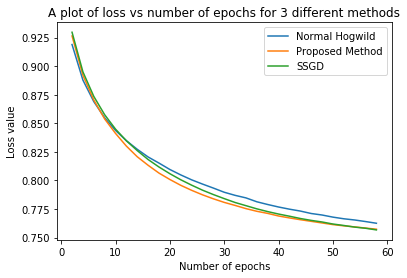

In [25]:
sta = 2
y = 31 - sta
x = np.arange(y) * 2 + sta
plt.plot(x,loss_iter_1[sta:],label='Normal Hogwild')
plt.plot(x,loss_iter_2[sta:],label='Proposed Method')
plt.plot(x,loss_iter_3[sta:],label='SSGD')
plt.legend()
plt.ylabel('Loss value')
plt.xlabel('Number of epochs')
plt.title('A plot of loss vs number of epochs for 3 different methods')

Text(0, 0.5, 'Number of parallel computations in 60 epochs')

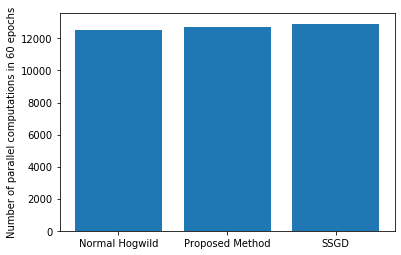

In [26]:
plt.bar(['Normal Hogwild','Proposed Method','SSGD'],[total_iter_1 / t,total_iter_2 / t,total_iter_3 / t])
plt.ylabel('Number of parallel computations in 60 epochs')

Text(0.5, 1.0, 'A plot of loss vs number of pool iterations for 3 different methods')

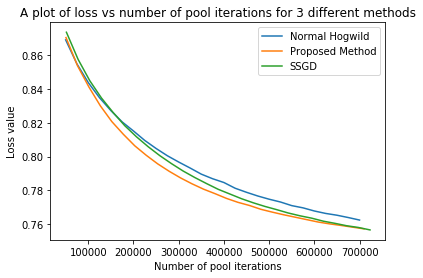

In [36]:
sta = 4
y = 31 - sta
x = np.arange(y) * 2 + sta
plt.plot(x*total_iter_1 / t,loss_iter_1[sta:],label='Normal Hogwild')
plt.plot(x*total_iter_2 / t,loss_iter_2[sta:],label='Proposed Method')
plt.plot(x*total_iter_3 / t,loss_iter_3[sta:],label='SSGD')
plt.legend()
plt.ylabel('Loss value')
plt.xlabel('Number of pool iterations')
plt.title('A plot of loss vs number of pool iterations for 3 different methods')

Text(0.5, 1.0, 'A plot of loss vs time elapsed for 3 different methods')

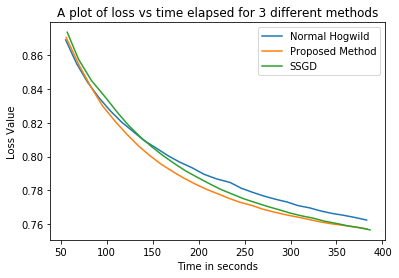

In [28]:
sta = 4
plt.plot(time_iter_1[sta:],loss_iter_1[sta:],label='Normal Hogwild')
plt.plot(time_iter_2[sta:],loss_iter_2[sta:],label='Proposed Method')
plt.plot(time_iter_3[sta:],loss_iter_3[sta:],label='SSGD')
plt.legend()
plt.ylabel('Loss Value')
plt.xlabel('Time in seconds')
plt.title('A plot of loss vs time elapsed for 3 different methods')